# Lendo dados experimentais


   vazao    h1    h2
0    0.0 -0.47 -0.06
1    0.0 -0.57 -0.06
2    0.0 -0.57 -0.16
3    0.0 -0.07 -0.16
4    0.0 -0.47 -0.06


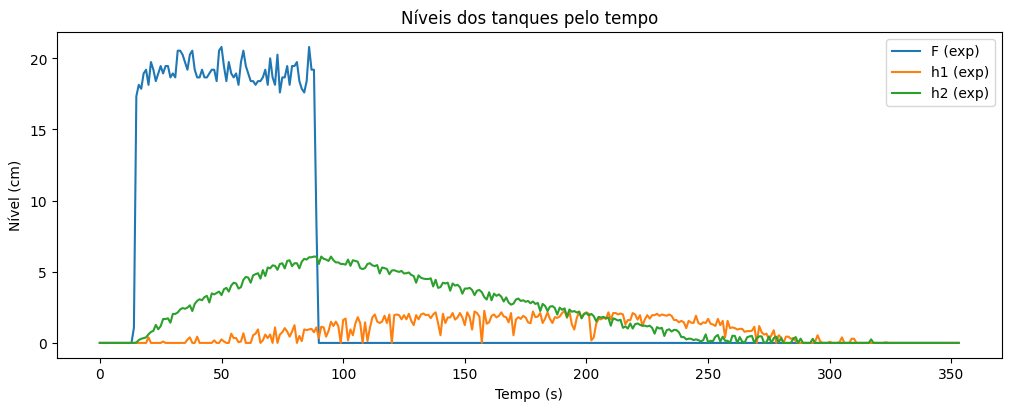

In [15]:
import numpy as np
import pandas as pd

from plot import plot_tanks

exp_data = pd.read_csv("../dados.csv")

F_exp = exp_data["vazao"].to_numpy() * 2
h1_exp = np.clip(exp_data["h1"].to_numpy(), 0.0, None)
h2_exp = np.clip(exp_data["h2"].to_numpy(), 0.0, None)
t = np.arange(len(F_exp))

print(exp_data.head())

plot_tanks(t, [F_exp, h1_exp, h2_exp], ["F (exp)", "h1 (exp)", "h2 (exp)"])


# Definindo sistema


In [16]:
import numpy as np
from scipy.integrate import solve_ivp


def F(t: float | int):
    return F_exp[int(t)]


def edo(t, Y, cv1, cv2):
    # Constantes
    a2 = 10 * 15  # cm^2
    a1 = np.pi * (11 / 2) ** 2  # cm^2
    # a2 = 160.0
    # a1 = 95.03

    # Dependent variables
    h2, h1 = Y[0], Y[1]

    # Tanks limits
    h2 = np.where(h2 < 0.0, 0.0, h2)
    h1 = np.where(h1 < 0.0, 0.0, h1)

    # Equations
    dh2dt = (F(t) / a2) - ((cv2 * np.sqrt(h2)) / a2)
    dh1dt = ((cv2 * np.sqrt(h2)) / a1) - ((cv1 * np.sqrt(h1)) / a1)
    return [dh2dt, dh1dt]


def simulate(c1, c2):
    sol = solve_ivp(
        edo,
        [t[0], t[-1]],
        [h1_exp[0], h2_exp[0]],
        t_eval=t,
        method="RK45",
        args=(c1, c2),
    )
    return sol.y


# Definindo função objetivo


In [17]:
import concurrent.futures


def loss(C):
    c1, c2 = C
    h2_sim, h1_sim = simulate(c1, c2)
    total_loss = np.mean(np.square(h1_exp - h1_sim)) + np.mean(
        np.square(h2_exp - h2_sim)
    )

    # print(f"c1: {c1}, c2: {c2}, loss: {total_loss}")
    return total_loss


# Otimizando pelo Scipy
# from scipy.optimize import minimize
# bounds = [(0, None), (0, None)]
# result = minimize(loss, [0, 0], method="Powell", bounds=bounds)

# Visualizando a função objetivo
c1_vals = np.linspace(0, 8, 200)  # Intervalo de valores para c1
c2_vals = np.linspace(0, 8, 200)  # Intervalo de valores para c2
C1, C2 = np.meshgrid(c1_vals, c2_vals)

# Calculando em paralelo os valores para maior velocidade
combinations = [
    (C1[i, j], C2[i, j]) for i in range(C1.shape[0]) for j in range(C1.shape[1])
]
Z = np.zeros_like(C1)

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(loss, combinations))

for idx, result in enumerate(results):
    i, j = divmod(idx, C1.shape[1])
    Z[i, j] = result


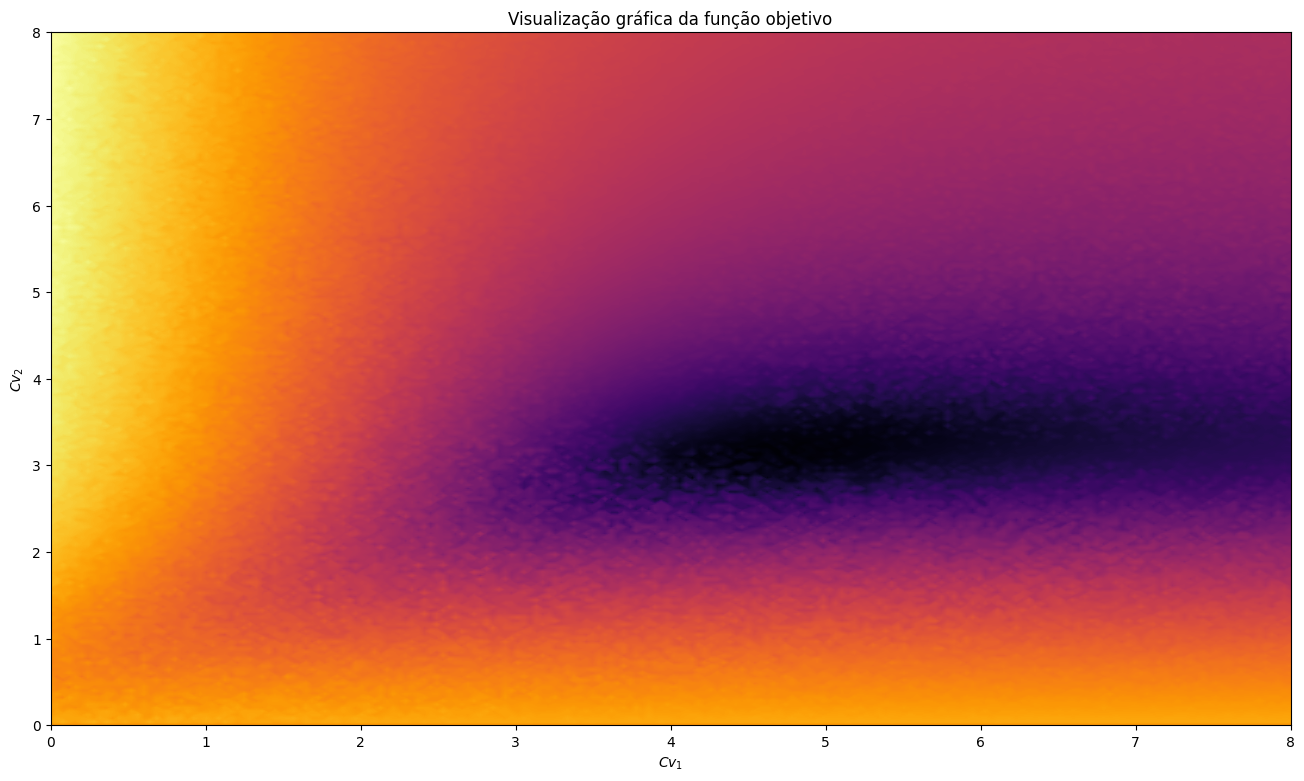

In [18]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Plotando o gráfico
plt.figure(figsize=(16, 9))
plt.contourf(
    C1,
    C2,
    Z,
    levels=np.logspace(np.log10(np.min(Z)), np.log10(np.max(Z)), 5000),
    cmap="inferno",
    norm=mcolors.LogNorm(),
)
# plt.colorbar()
plt.xlabel("$Cv_1$")
plt.ylabel("$Cv_2$")
plt.title("Visualização gráfica da função objetivo")
plt.show()


# Implementação do algorítimo genético clássico


In [19]:
from genetic_operators import crossover, mutate


# Função de avaliação do fitness (quanto menor o valor da função, melhor)
def fitness(individual):
    x, y = individual
    return -loss([x, y])  # Negativo porque estamos minimizando


# Inicializa a população com indivíduos aleatórios
def initialize_population(pop_size, bounds):
    population = []
    for _ in range(pop_size):
        x = np.random.uniform(bounds[0][0], bounds[0][1])
        y = np.random.uniform(bounds[1][0], bounds[1][1])
        population.append([x, y])
    return np.array(population)


# Seleção de pais por torneio
def tournament_selection(population, fitnesses, k=3):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmax(fitnesses[selected])]
    return population[best]


# Algoritmo Genético
def genetic_algorithm(
    pop_size, bounds, generations, crossover_rate=0.8, mutation_rate=0.1
):
    # Inicializar a população
    population = initialize_population(pop_size, bounds)
    best_solution = []
    best_fitness = -np.inf

    for generation in range(generations):
        # Avaliar o fitness de cada indivíduo
        fitnesses = np.array([fitness(ind) for ind in population])

        # Atualizar o melhor indivíduo
        current_best_idx = np.argmax(fitnesses)
        current_best_fitness = fitnesses[current_best_idx]
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[current_best_idx]

        # Nova população
        new_population = []

        while len(new_population) < pop_size:
            # Selecionar pais
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)

            # Realizar crossover
            child1, child2 = crossover(parent1, parent2, crossover_rate)

            # Realizar mutação
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            # Adicionar filhos à nova população
            new_population.append(child1)
            if len(new_population) < pop_size:
                new_population.append(child2)

        population = np.array(new_population)

        print(
            f"Geração {generation + 1}: Melhor solução = {best_solution}, Melhor fitness = {-best_fitness}"
        )

    return best_solution, -best_fitness


# Definir os parâmetros do algoritmo
pop_size = 50
bounds = [(0, 5), (0, 5)]  # Limites para x e y
generations = 50

# Executar o algoritmo genético
best_solution, best_fitness = genetic_algorithm(pop_size, bounds, generations)

print(f"Melhor solução encontrada: {best_solution}")
print(f"Valor da função objetivo na melhor solução: {best_fitness}")


Geração 1: Melhor solução = [4.70629932 2.86489591], Melhor fitness = 0.396191078120844
Geração 2: Melhor solução = [4.61537549 2.98515261], Melhor fitness = 0.359144735106699
Geração 3: Melhor solução = [4.61537549 2.98515261], Melhor fitness = 0.359144735106699
Geração 4: Melhor solução = [4.57168524 3.02905596], Melhor fitness = 0.34038762163894215
Geração 5: Melhor solução = [4.57168524 3.02905596], Melhor fitness = 0.34038762163894215
Geração 6: Melhor solução = [4.59262179 3.04518091], Melhor fitness = 0.3395873330402654
Geração 7: Melhor solução = [4.59262179 3.04518091], Melhor fitness = 0.3395873330402654
Geração 8: Melhor solução = [4.59262179 3.04518091], Melhor fitness = 0.3395873330402654
Geração 9: Melhor solução = [4.59262179 3.04518091], Melhor fitness = 0.3395873330402654
Geração 10: Melhor solução = [4.49476272 3.00997528], Melhor fitness = 0.3382755952564078
Geração 11: Melhor solução = [4.49476272 3.00997528], Melhor fitness = 0.3382755952564078
Geração 12: Melhor s

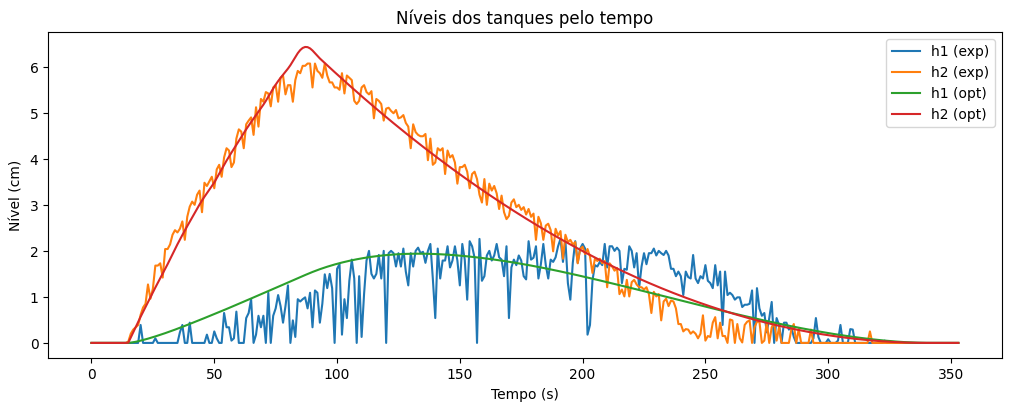

In [20]:
cv1_salomão = 3.582
cv2_salomão = 2.869

h2_opt, h1_opt = simulate(best_solution[0], best_solution[1])
# h2_opt, h1_opt = simulate(cv1_salomão, cv2_salomão)

plot_tanks(
    t,
    [h1_exp, h2_exp, h1_opt, h2_opt],
    ["h1 (exp)", "h2 (exp)", "h1 (opt)", "h2 (opt)"],
)
